# Principal Component Analysis

흔히, PCA라고 불리는 것인데요, 보통 dimensionality reduction 용도로 많이 아시고 계실 겁니다.
하지만, PCA는 dimensionality reduction 용도로만 쓰이는 것은 아닙니다.

PCA의 역할은 데이터로부터 축을 찾아내는 것인데, 그 축들 방향으로 데이터를 정사영하면 모두 상관관계가 0이라는 특징이 있습니다.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from utils.data_generator import generate_simple_dataset

utils 폴더에 간단한 데이터를 만드는 함수를 정의해두었습니다. 이것을 이용해서 데이터를 생성해봅니다.

In [2]:
x = generate_simple_dataset()

print(f"Shape of x: {x.shape}")

Shape of x: (100, 5)


그러나, 데이터가 5차원이라 시각화를 바로 못해볼 것 같습니다. 따라서, scikit-learn의 PCA를 통해 먼저 차원을 2차원으로 축소한 뒤 시각화를 하고, numpy로 구현을 직접 해보도록 하겠습니다. scikit-learn의 PCA로 시각화한 것은 또, 우리가 나중에 구현할 PCA의 결과의 모범답안으로 비교를 할 수 있을 겁니다.

그 전에, PCA는 항상 zero-centered 데이터가 들어가야 합니다. 이건 PCA의 데이터에 대한 assumption으로 반드시 맞춰주는게 좋습니다. 가정이 틀려버리면 그 이후가 의미가 없죠. 다음 식은 데이터의 평균을 0로 맞춰주는 역할을 합니다.

In [3]:
x_centered = x - np.mean(x, axis=0, keepdims=True)

## PCA implementation in Scikit-Learn

PCA를 직접 구현하기 전에 scikit-learn 안에 구현되어 있는 PCA의 dimensionality reducction 결과를 먼저 보겠습니다. 먼저, PCA를 import합니다.

In [4]:
from sklearn.decomposition import PCA

시각화를 쉽게 하기 위해 5차원 feature를 2차원으로 축소할겁니다. n_components=2로 PCA를 생성해줍니다.

In [5]:
pca = PCA(n_components=2)

PCA를 학습시킬 것입니다. ``.fit``함수를 호출하여 PCA를 학습시킨 후, ``.transform``함수를 이용하여 데이터를 변환 및 축소시킵니다.

In [6]:
pca.fit(x_centered)
x_original_pca = pca.transform(x_centered)

Scikit-learn으로 축소한 데이터를 시각화해보겠습니다.

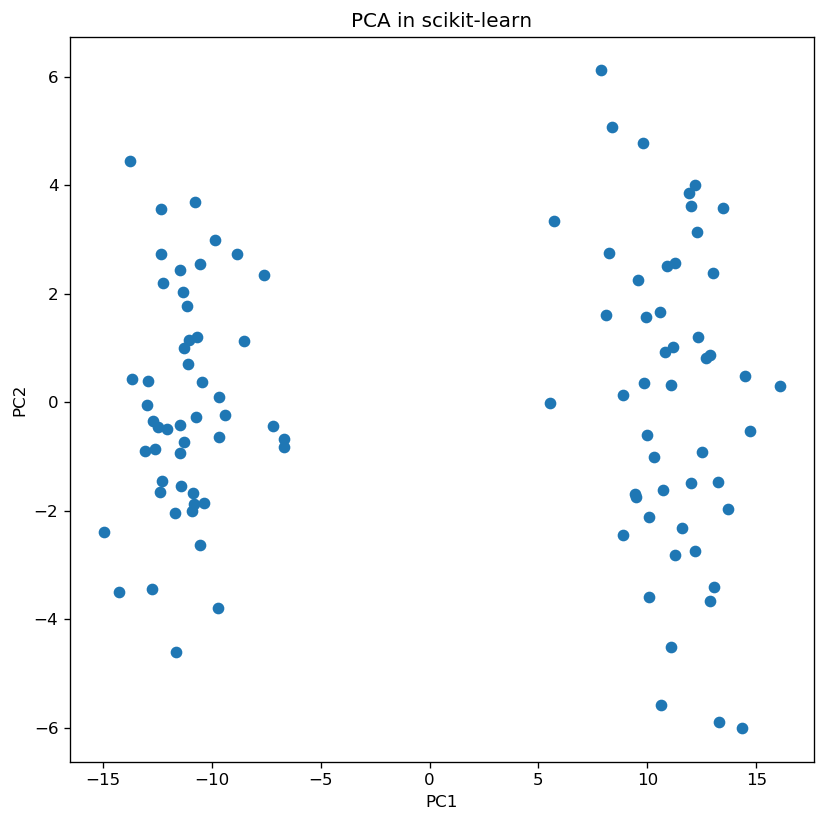

In [7]:
plt.figure(figsize=(8, 8), dpi=120)
plt.scatter(x_original_pca[:, 0], x_original_pca[:, 1])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA in scikit-learn")
plt.show()

이 PCA 시각화를 잘 봐두시길 바랍니다. 우리의 PCA 구현체도 비슷하게 나오면 성공일 겁니다.

## PCA implementation in Numpy

PCA를 numpy로 구현해볼겁니다. Scikit-learn 클래스의 형식대로 ``.fit``메소드와 ``.transform``메소드를 구현할 겁니다.

In [53]:
class PrincipalComponentAnalysis():
    """
    PCA 구현체
    """
    
    def __init__(self, n_components):
        """
        생성자
        
        Arguments:
        ----------
        - n_components 양의 정수값. 데이터를 축소시킬 목표 차원
        """
        
        self.n_components = n_components
        
        # 학습이 이루어지면 self.eigen_mat이 None이 아닌 eigen vector matrix가 된다.
        self.eigen_mat = None
        
        # 학습이 이루어지면 self.eigen_val이 None이 아닌 eigen value vector가 된다.
        self.eigen_val = None
        
    def fit(self, x):
        """
        PCA 학습
        2차원 데이터를 받아서 feature 차원을 n_components차원의 feature 차원으로 압축시킬 수 있도록
        Eigen vector matrix를 계산한다.
        
        Arguments:
        ----------
        - x 2차원 텐서. 데이터
        """
        
        # n: batch size, d: feature dimension
        n, d = x.shape
        
        # feature의 covariance matarix 계산
        # np.cov(x_std.T)
        cov = np.matmul(x.T, x)/n
        
        # eigen value, eigen vector 계산
        eigvals, eigvecs = np.linalg.eig(cov)
        
        # eigen value를 이용하여 sorting하기 위한 객체
        eig_pairs = [(eigvals[i], eigvecs[:, i]) for i in range(d)]
        
        # sort in descending order by eigen value
        sorted_eig = sorted(eig_pairs, key=lambda tup: tup[0], reverse=True)
        
        # eigen vector만 가져와서 행렬로 만듦
        self.eigen_mat = np.stack(list(map(lambda tup: tup[1], sorted_eig)), axis=1)
        
        # eigen value만 가져와서 벡터로 만듦
        self.eigen_val = np.array(list(map(lambda tup: tup[0], sorted_eig)))
        
    def transform(self, x):
        """
        PCA 변환
        계산해둔 eigen vector들을 이용하여 데이터의 feature 차원을 n_components 차원으로 차원축소시킨다.
        
        Arguments:
        ----------
        - x 2차원 텐서, 데이터
        
        Returns:
        - results (batch_size, n_components) 차원의 텐서, 변환된 데이터
        """
        
        # fit 호출 전이면 에러메시지 출력후 종료
        if self.eigen_mat is None:
            print("You should fit model first!")
            return
        
        # n_components개의 eigen vector만 추출
        reduced_eigen_mat = self.eigen_mat[:, :self.n_components]
        
        # dimensionality reduction 수행
        results = np.matmul(x, reduced_eigen_mat)
        
        return results

이제, PCA 객체를 생성합니다.

In [9]:
pca = PrincipalComponentAnalysis(n_components=2)

PCA를 학습시켜봅니다.

In [10]:
pca.fit(x_centered)

이제, 다시 scikit-learn의 PCA로 변환시키는데 이용했던 같은 데이터를 우리가 만든 PCA로 변환해보겠습니다.

In [11]:
x_transformed = pca.transform(x_centered)

print(f"Shape of transformed x: {x_transformed.shape}")

Shape of transformed x: (100, 2)


잘 변환되었는지 시각화를 통해 확인해보죠.

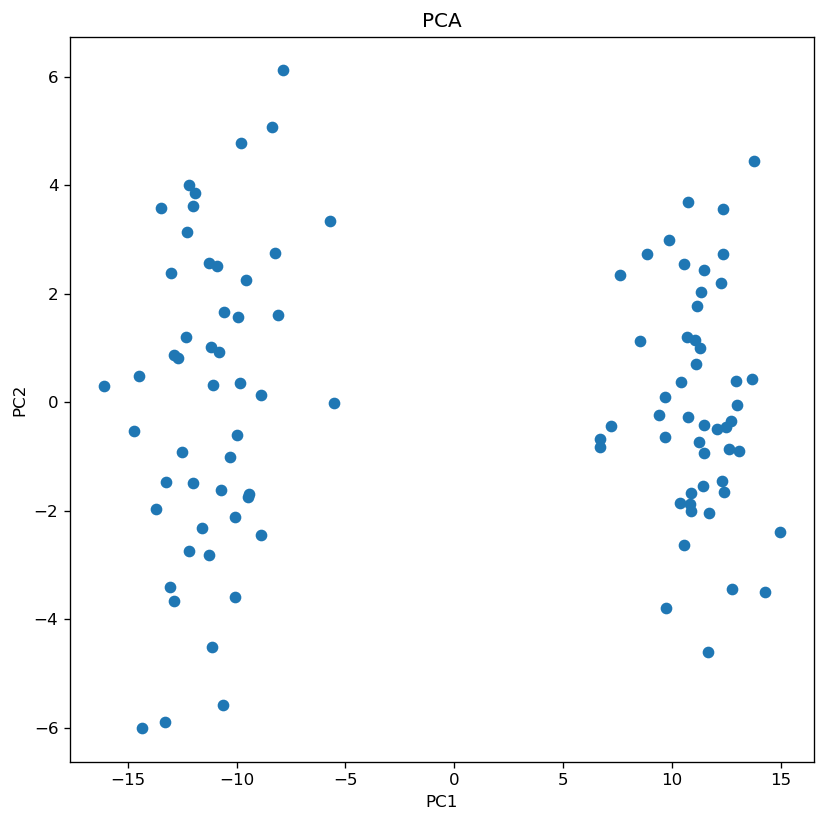

In [12]:
plt.figure(figsize=(8, 8), dpi=120)
plt.scatter(x_transformed[:, 0], x_transformed[:, 1])
plt.title("PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

아까 scikit-learn의 PCA랑 유사한 플롯이 나왔습니다. 나름 차원축소를 잘 한것으로 보이네요.

### Whitening

PCA의 용도는 dimensionality reduciton도 있지만, whitening도 있습니다. Whitening은 각 축 방향으로 분산을 모두 1로 (또는 똑같게) 만들어 주면서, 다른 축과의 covariance을 0으로 만들어 주는 과정을 말합니다.

일단, PCA를 해 주게 되면 기본적으로 PC끼리 covariance가 0이 됩니다.
그리고, 각 축의 분산은 eigen value 이므로, 각 축을 eigen value로 나눠주기만 하면 whitening이 됩니다.

PCA를 생성해봅시다. 단, 우리는 차원축소 없이 whitening만 수행할 것이므로, n_components는 데이터와 같은 5로 유지합니다.

In [54]:
pca = PrincipalComponentAnalysis(n_components=5)

학습부터 변환을 시켜봅니다.

In [55]:
pca.fit(x_centered)

In [56]:
x_transformed = pca.transform(x_centered)

이제, 이 변환된 데이터를 eigen value의 제곱근으로 나눠줄겁니다. eigen value는 분산이므로, 표준편차로 바꿔주고 나눠주어야 합니다.

In [70]:
x_whiten = x_transformed / np.sqrt(np.expand_dims(pca.eigen_val, axis=0))

이 데이터의 covariance를 계산해보겠습니다. covariance matrix가 identity matrix 형태가 나오면 whitening의 조건을 모두 만족하게 됩니다.
대각성분이 모두 1이면 모든 축에서의 분산은 1이라는 의미이고, 비대각성분이 0이면 다른 축과의 covariance이 0이라는 의미이죠.

즉, covariance matrix가 identity matrix가 나오면 됩니다.

다음은 covariance matrix를 계산하는 식입니다.

In [77]:
N = x_whiten.shape[0]
cov = np.matmul(x_whiten.T, x_whiten) / N

In [78]:
cov

array([[ 1.00000000e+00,  3.83026943e-16,  7.72715225e-16,
        -2.48689958e-16,  8.70414851e-16],
       [ 3.83026943e-16,  1.00000000e+00,  1.03111963e-15,
         1.56319402e-15, -9.75886039e-16],
       [ 7.72715225e-16,  1.03111963e-15,  1.00000000e+00,
        -2.39808173e-15,  1.33892897e-15],
       [-2.48689958e-16,  1.56319402e-15, -2.39808173e-15,
         1.00000000e+00,  1.25233157e-15],
       [ 8.70414851e-16, -9.75886039e-16,  1.33892897e-15,
         1.25233157e-15,  1.00000000e+00]])

이 covariance matrix를 보면, 의미없는 숫자가 좀 많은 것 같네요. 0.0000000000012 보다 작은 수는 모두 0으로, 1.0000000000012 보다 작고 0.999999999998 보다 큰 수는 1로 바꿔보겠습니다.

In [79]:
cov[cov < 1e-12] = 0
cov[(cov < 1 + 1e-12) & (cov > 1 - 1e-12)] = 1
cov

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

네, 매우 작은 오차들이 있었지만, 그 오차를 제거해주니 identity matrix가 나옴을 확인할 수 있습니다. 이처럼, PCA는 dimensionality reduction 뿐 아니라, whitening에도 이용할 수 있습니다.